# TravelTide - customer segmentation
- k-means
    K Means belongs to a general class of Machine Learning algorithms called Unsupervised Learners. K Means is a clustering algorithm, which means it groups data into clusters. K Means is a centroid-based algorithm, which means it attempts to minimize the distance between data points and their centroid. It does this by iteratively calculating the centroid of each cluster and reassigning data points to the nearest centroid.

    In other words, K-means is a distance-based segmentation that segments customers by behavioral data based on “similarity”, as defined by a distance metric like the Euclidean. Under this perspective, two customers are said to be similar in real life if they are nearby in behavioral data space.

- We will use agg + segments data extracted using SQL for this segmentation using K-means

In [1]:
# import required libraries

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.impute import SimpleImputer  # Import the imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# Load data with metrics
df = pd.read_csv('data/traveltide-agg-seg-full-2023-08-29_52908.csv', usecols=['user_id', 'avg_hotel_discount_amount', 'avg_checked_bags', 'num_cancellation', 'bargain_hunter_index', 'num_flight_booked', 'num_hotel_booked'])

In [3]:
print(df.shape)
df.head()

(5998, 7)


,user_id,avg_hotel_discount_amount,num_flight_booked,num_hotel_booked,num_cancellation,avg_checked_bags,bargain_hunter_index
0,23557,0.175,0,2,0,NaN,NaN
1,94883,0.100,2,2,0,0.5,NaN
2,101486,NaN,1,2,0,0.0,NaN
3,101961,0.100,5,5,0,0.4,0.000027
4,106907,NaN,2,2,1,5.0,NaN


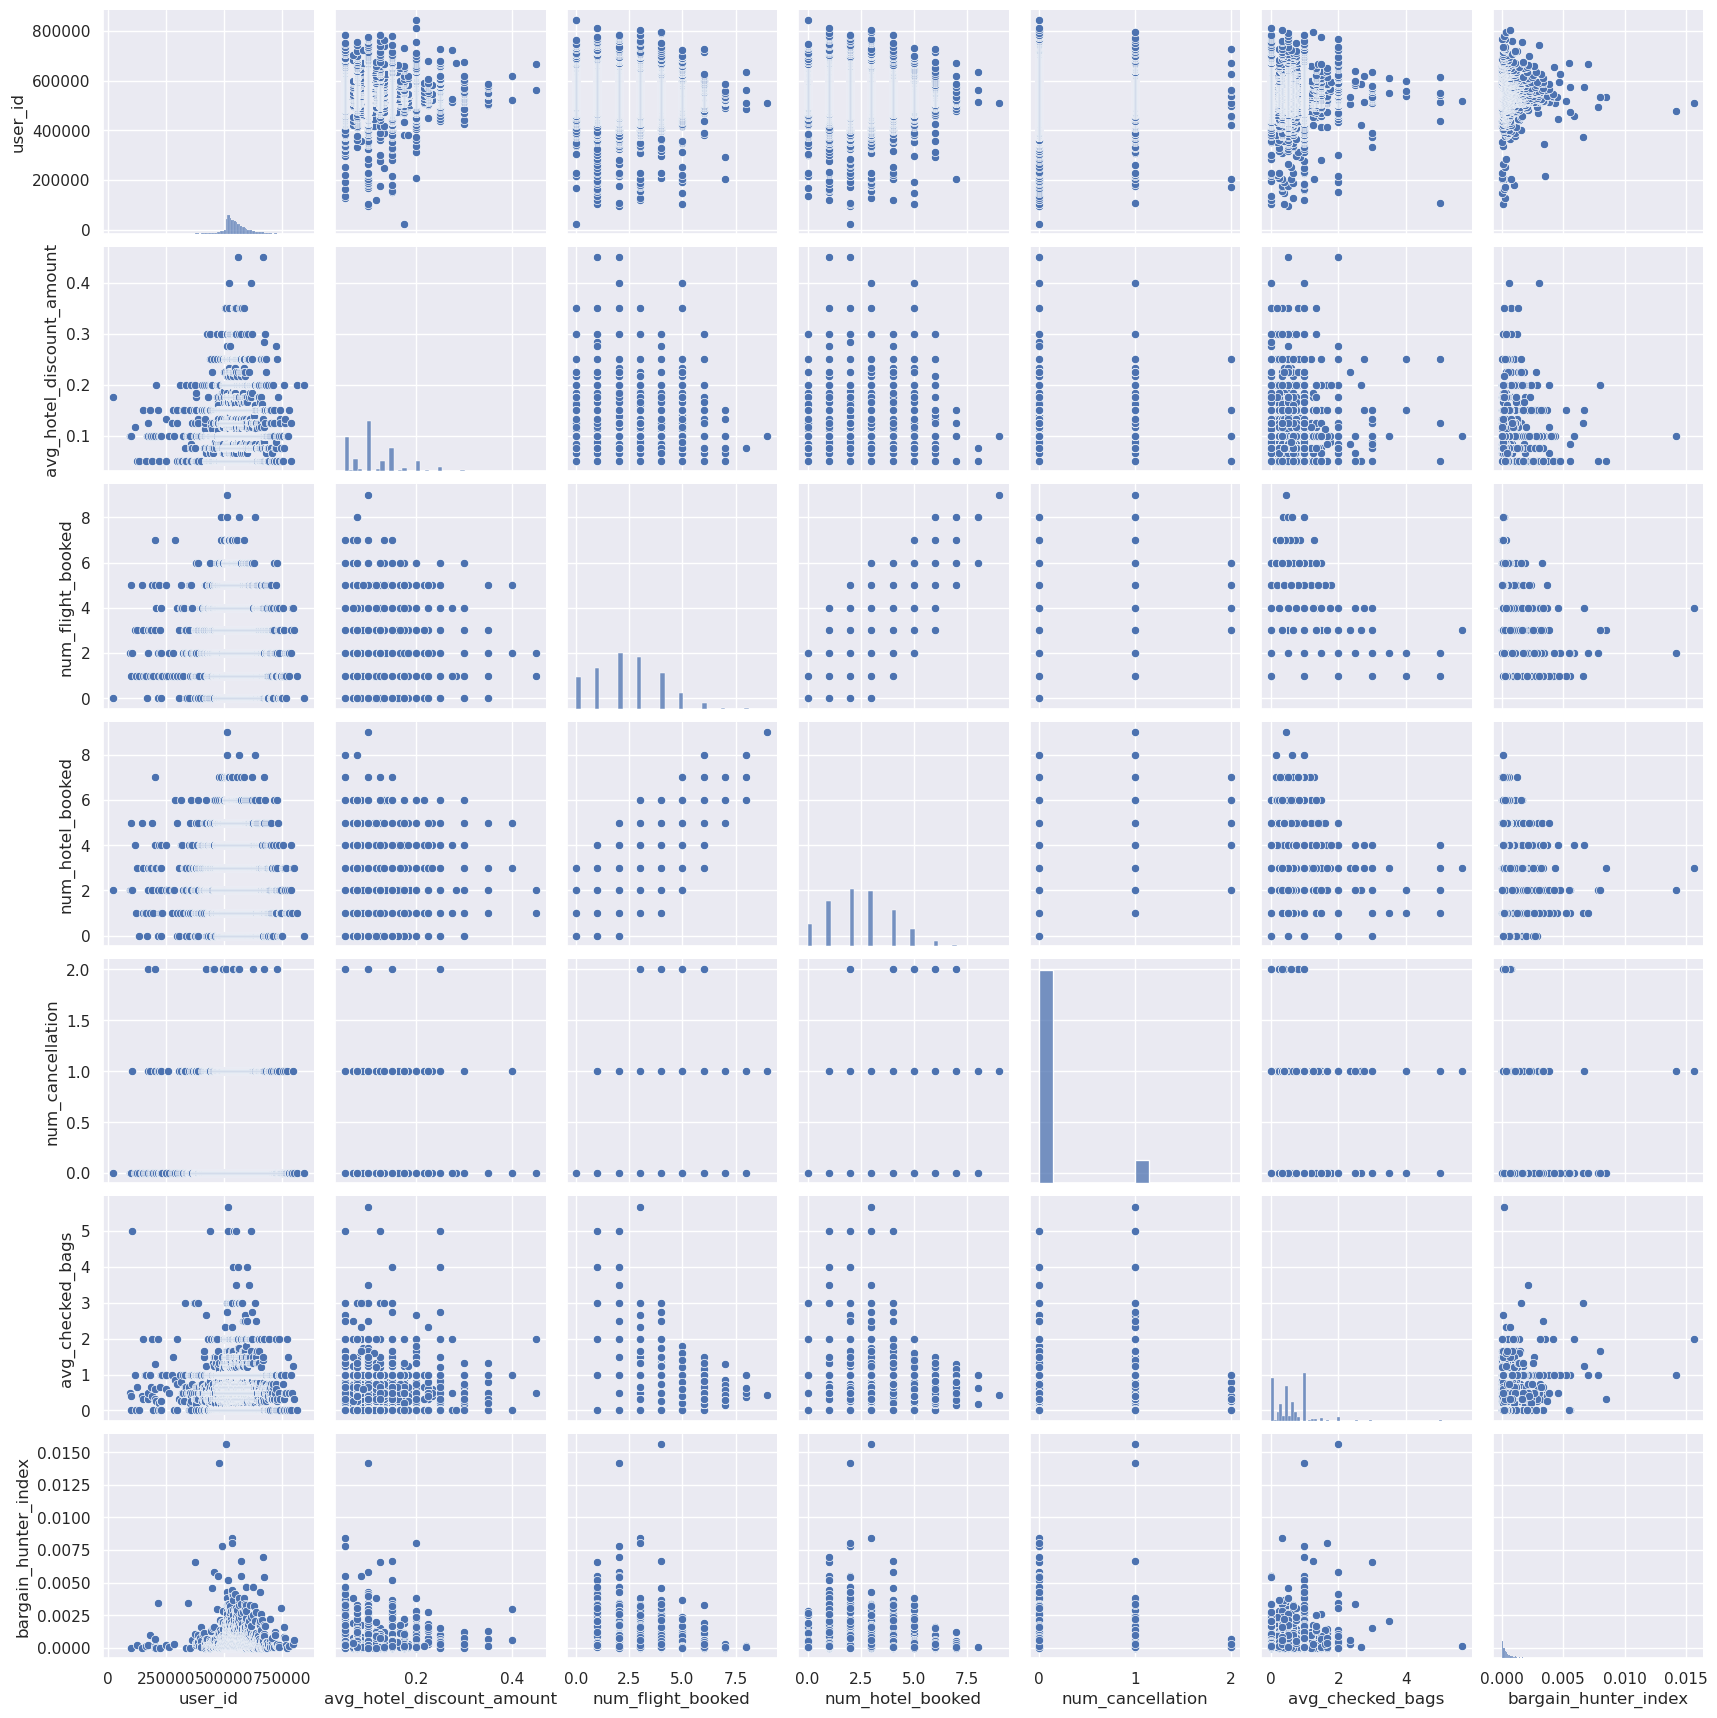

In [4]:
# Visualize the Data

sns.pairplot(df)
plt.show()

## Normalizing the Data

In [5]:
# Select the columns for clustering
features = ['avg_hotel_discount_amount', 'avg_checked_bags', 'num_cancellation', 'bargain_hunter_index', 'num_flight_booked', 'num_hotel_booked']

# Handle missing values with imputation
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

# Normalize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Number of clusters
num_clusters = 5

In [6]:
df.head()

,user_id,avg_hotel_discount_amount,num_flight_booked,num_hotel_booked,num_cancellation,avg_checked_bags,bargain_hunter_index
0,23557,1.425030e+00,-1.527351,-0.325163,-0.327625,0.000000,0.000000
1,94883,-2.631538e-01,-0.247875,-0.325163,-0.327625,-0.210975,0.000000
2,101486,-3.123768e-16,-0.887613,-0.325163,-0.327625,-1.267582,0.000000
3,101961,-2.631538e-01,1.671340,1.676541,-0.327625,-0.422297,-1.041192
4,106907,-3.123768e-16,-0.247875,-0.325163,2.893840,9.298486,0.000000


## Fit data to k-means model for clustering

In [7]:
# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(df[features])

# Extract cluster labels
labels = kmeans.labels_

# Map cluster labels to user_id column in the DataFrame
df['cluster'] = labels

# Print the cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("Cluster labels:")
print(labels)

Cluster Centers:
[[-2.55791333e-01 -2.33489383e-02 -3.27624760e-01  1.50907268e-02
  -8.70910251e-01 -8.53309544e-01]
 [-2.39898620e-01 -7.38727483e-02 -3.27624760e-01 -1.87070562e-01
   7.30644743e-01  7.39971725e-01]
 [ 2.09379471e+00  5.25042678e-03 -3.22117983e-01 -2.26555138e-02
  -1.03523389e-01 -9.47673019e-02]
 [-1.44861874e-01  5.87525112e-01  2.49353946e-01  6.83856981e+00
  -9.51012694e-02 -7.61947056e-02]
 [-5.83127479e-02  3.22302641e-01  2.97686712e+00 -7.13775482e-02
   7.74387653e-01  6.52760001e-01]]
Cluster labels:
[2 0 0 ... 1 2 2]


/home/ranga/anaconda3/envs/masterschool-da/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Evaluate performance of the clustering algorithm using a Silhouette score 
silhouette_score = silhouette_score(df[features], df['cluster'], metric='euclidean')
print(f"Silhouette Score: {silhouette_score:.2f}")

Silhouette Score: 0.30


In [9]:
# Create a dictionary to map cluster numbers to labels
cluster_labels = {
    0: "Cluster 1",
    1: "Cluster 2",
    2: "Cluster 3",
    3: "Cluster 4",
    4: "Cluster 5"
}

# Map cluster numbers to labels
df['cluster_label'] = df['cluster'].map(cluster_labels)

In [10]:
# Print the DataFrame with added cluster information
df.head()

,user_id,avg_hotel_discount_amount,num_flight_booked,num_hotel_booked,num_cancellation,avg_checked_bags,bargain_hunter_index,cluster,cluster_label
0,23557,1.425030e+00,-1.527351,-0.325163,-0.327625,0.000000,0.000000,2,Cluster 3
1,94883,-2.631538e-01,-0.247875,-0.325163,-0.327625,-0.210975,0.000000,0,Cluster 1
2,101486,-3.123768e-16,-0.887613,-0.325163,-0.327625,-1.267582,0.000000,0,Cluster 1
3,101961,-2.631538e-01,1.671340,1.676541,-0.327625,-0.422297,-1.041192,1,Cluster 2
4,106907,-3.123768e-16,-0.247875,-0.325163,2.893840,9.298486,0.000000,4,Cluster 5


In [11]:
df

,user_id,avg_hotel_discount_amount,num_flight_booked,num_hotel_booked,num_cancellation,avg_checked_bags,bargain_hunter_index,cluster,cluster_label
0,23557,1.425030e+00,-1.527351,-0.325163,-0.327625,0.000000,0.000000,2,Cluster 3
1,94883,-2.631538e-01,-0.247875,-0.325163,-0.327625,-0.210975,0.000000,0,Cluster 1
2,101486,-3.123768e-16,-0.887613,-0.325163,-0.327625,-1.267582,0.000000,0,Cluster 1
3,101961,-2.631538e-01,1.671340,1.676541,-0.327625,-0.422297,-1.041192,1,Cluster 2
4,106907,-3.123768e-16,-0.247875,-0.325163,2.893840,9.298486,0.000000,4,Cluster 5
...,...,...,...,...,...,...,...,...,...
5993,792549,-3.123768e-16,1.031602,-0.992397,-0.327625,-0.210975,0.000000,1,Cluster 2
5994,796032,-3.123768e-16,1.031602,0.342072,2.893840,1.373935,-0.528453,4,Cluster 5
5995,801660,-3.123768e-16,0.391864,0.342072,-0.327625,-0.563178,0.136414,1,Cluster 2
5996,811077,1.987758e+00,-0.887613,-0.992397,-0.327625,-1.267582,0.000000,2,Cluster 3


### Visualize the clustering results

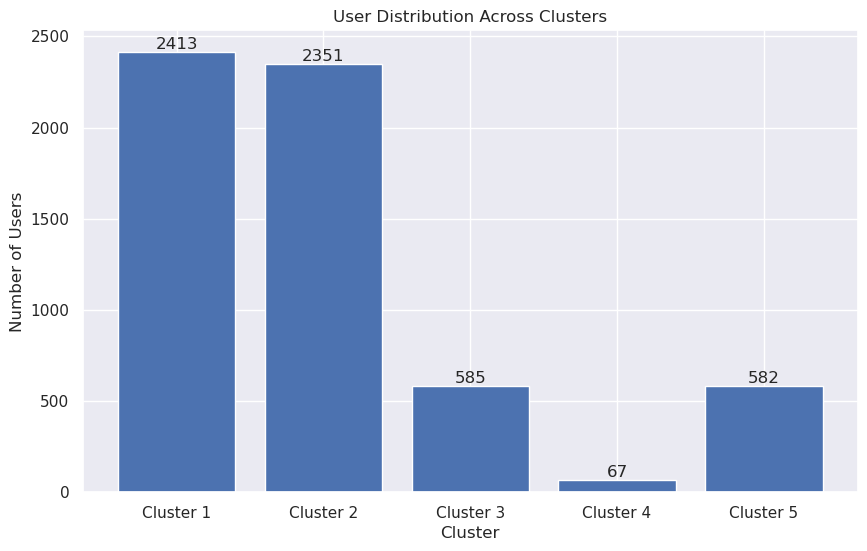

In [12]:
# Count the number of users in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Create a bar plot to visualize user distribution across clusters
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('User Distribution Across Clusters')
plt.xticks(cluster_counts.index, [f'Cluster {i+1}' for i in cluster_counts.index])

# Add value counts on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

### Save the segmentation results 

In [13]:
# Create the new DataFrame 'customer_segmented_kmeans'
customer_segmented_kmeans = df[['user_id', 'cluster_label']]

In [14]:
# Create the new DataFrame 'customer_segmented_kmeans'
customer_segmented_kmeans = df[['user_id', 'cluster_label']].rename(columns={'cluster_label': 'assigned_segment'})

In [15]:
customer_segmented_kmeans

,user_id,assigned_segment
0,23557,Cluster 3
1,94883,Cluster 1
2,101486,Cluster 1
3,101961,Cluster 2
4,106907,Cluster 5
...,...,...
5993,792549,Cluster 2
5994,796032,Cluster 5
5995,801660,Cluster 2
5996,811077,Cluster 3


In [16]:
# Save the new DataFrame to a CSV file
customer_segmented_kmeans.to_csv('data/output/customer_segmented_kmeans.csv', index=False)